# Generate multilayer networks

In [ ]:
import generate_network, importlib
importlib.reload(generate_network)
from generate_network import *
import os

import numpy as np

N = 500
L = 5
n0 = 500
n_sets = 10
mu = 0.25
k_min = 5
k_max = 50
t_k = -2.0
theta = 1.0
churn = 0.0

p_stay_values = [round(x, 1) for x in np.arange(0.1, 0.9, 0.1)]

os.makedirs("sync_data", exist_ok=True)

def fmt_decimal(val: float):
    # val=0.1 -> "0.1" -> split ["0","1"] -> "01"
    s = f"{val:.1f}"  # '0.1'
    whole, frac = s.split(".")  # whole='0', frac='1'
    return f"{whole}{frac.zfill(1)}"  # '01'


for p_stay in p_stay_values:
    join_rate = churn
    leaving_rate = churn

    p_stay_tag = fmt_decimal(p_stay)

    filename = f"const-p{p_stay_tag}.csv"
    output_path = os.path.join("sync_data", filename)

    print(f"Generating {output_path} (p_stay={p_stay})")

    generate_multilayer_network(
        node_pool=N,
        layer=L,
        init_size=n0, 
        n_sets=n_sets,
        mu=mu,
        k_min=k_min,
        k_max=k_max,
        t_k=t_k,
        theta=theta,
        p_stay=p_stay,
        join_rate=join_rate,
        leaving_rate=leaving_rate,
        output_path=output_path
    )

/Users/peijiezhong/Desktop/research/multilayer/.venv/lib/python3.12/site-packages/nxmultilayer.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


Generating sync_data/const-p01.csv (p_stay=0.1)
[{'layer': 0, 'size': 500, 'survivors': 500, 'entrants': 500, 'jaccard_with_prev': 1.0}, {'layer': 1, 'size': 500, 'survivors': 500, 'entrants': 0, 'jaccard_with_prev': 1.0}, {'layer': 2, 'size': 500, 'survivors': 500, 'entrants': 0, 'jaccard_with_prev': 1.0}, {'layer': 3, 'size': 500, 'survivors': 500, 'entrants': 0, 'jaccard_with_prev': 1.0}, {'layer': 4, 'size': 500, 'survivors': 500, 'entrants': 0, 'jaccard_with_prev': 1.0}]
Generating sync_data/const-p02.csv (p_stay=0.2)
[{'layer': 0, 'size': 500, 'survivors': 500, 'entrants': 500, 'jaccard_with_prev': 1.0}, {'layer': 1, 'size': 500, 'survivors': 500, 'entrants': 0, 'jaccard_with_prev': 1.0}, {'layer': 2, 'size': 500, 'survivors': 500, 'entrants': 0, 'jaccard_with_prev': 1.0}, {'layer': 3, 'size': 500, 'survivors': 500, 'entrants': 0, 'jaccard_with_prev': 1.0}, {'layer': 4, 'size': 500, 'survivors': 500, 'entrants': 0, 'jaccard_with_prev': 1.0}]
Generating sync_data/const-p03.csv (p_

# Multilayer infomap --JSD

In [5]:
import algorithms, measurement, importlib
importlib.reload(algorithms)
importlib.reload(measurement)
from algorithms import *
from measurement import *

import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt


# ---------- 文件名解析 ----------
def parse_filename(path: str):
    fname = os.path.basename(path)
    m = re.match(r"const-p(\d+)\.csv", fname)
    if not m:
        raise ValueError(f"无法解析文件名: {fname}")

    pstay_tag = m.group(1)   # '04'

    def tag_to_float(tag: str) -> float:
        # '01' -> '0.1', '04' -> '0.4', '10' -> '1.0'
        if len(tag) == 1:
            # e.g. '5' -> '0.5'
            s = f"0.{tag}"
        else:
            s = tag[0] + "." + tag[1:]
        return float(s)
    p_stay_val = tag_to_float(pstay_tag)
    return p_stay_val

relax_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
csv_files = glob.glob("sync_data/const-p*.csv")

records = []

for file_path in csv_files:
    p_stay_val = parse_filename(file_path)
    print(f"\nProcessing file: {file_path} p_stay={p_stay_val})")

    for rate in relax_rates:
        try:
            partition = infomap_communities(file_path, None, jsd_relax_rate=rate)
            mami = compute_layerwise_ami_avg(file_path, partition)

            records.append({
                "p_stay": p_stay_val,
                "relax_rate": rate,
                "mami": mami,
                "file": os.path.basename(file_path),
            })

        except Exception as e:
            print(f"Error: {e}")

results_df = pd.DataFrame(records)
print("\n=== Summary DataFrame ===")
print(results_df)



Processing file: sync_data/const-p07.csv p_stay=0.7)
[0.984492639119357, 0.9952075401438528, 0.9821876615780374, 0.9927242327116685, 0.9849938776010283]
[0.9777196141735623, 0.9845599329312188, 0.9562882002379888, 0.9901573971278775, 0.9376250145176075]
[0.9786360610291515, 0.9032939782507438, 0.8979894927457274, 0.8785303718192568, 0.7702296347931566]
[0.982592892582859, 0.9640166218192127, 0.9404623652569862, 0.9330171210465622, 0.7694654260712005]
[0.9949555917184351, 0.9430934414920479, 0.9087201478705005, 0.9168602361292942, 0.7210716608953163]
[0.9903835205526182, 0.9173185277414136, 0.9023594260266975, 0.8796679868480181, 0.7189259420991101]

Processing file: sync_data/const-p06.csv p_stay=0.6)
[0.979052743453725, 0.9973354873170079, 0.9902506308422895, 0.9629517287551962, 0.9002685537776595]
[0.9760725835782026, 0.9797964500501343, 0.9536091214478494, 0.9516348251890704, 0.8301554319178253]
[0.979052743453725, 0.965090877157529, 0.9353666352033198, 0.8592525206333655, 0.748887

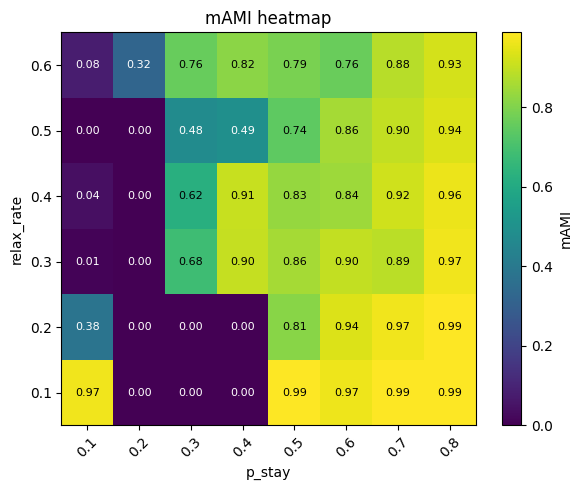

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 计算平均值 ===
heat_df = (
    results_df
    .groupby(["relax_rate", "p_stay"], as_index=False)["mami"]
    .mean()
)

# === 获取唯一取值 ===
relax_rates_unique = sorted(heat_df["relax_rate"].unique())
p_stay_unique = sorted(heat_df["p_stay"].unique())

# === 生成透视表 ===
pivot_mat = heat_df.pivot(index="relax_rate", columns="p_stay", values="mami")
pivot_mat = pivot_mat.reindex(index=relax_rates_unique, columns=p_stay_unique)

# === 绘图 ===
fig, ax = plt.subplots(figsize=(6, 5))

vmin = heat_df["mami"].min()
vmax = heat_df["mami"].max()

im = ax.imshow(
    pivot_mat.values,
    aspect="auto",
    origin="lower",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis"
)

# === 坐标轴 ===
ax.set_xticks(range(len(p_stay_unique)))
ax.set_xticklabels([str(v) for v in p_stay_unique], rotation=45)
ax.set_yticks(range(len(relax_rates_unique)))
ax.set_yticklabels([str(v) for v in relax_rates_unique])

ax.set_xlabel("p_stay")
ax.set_ylabel("relax_rate")
ax.set_title("mAMI heatmap")

# === 数值标注 ===
for i_rate, rate_val in enumerate(relax_rates_unique):
    for j_p, pstay_val in enumerate(p_stay_unique):
        val = pivot_mat.loc[rate_val, pstay_val]
        if pd.notna(val):
            text_color = "white" if val < (vmin + vmax) / 2 else "black"
            ax.text(
                j_p,
                i_rate,
                f"{val:.2f}",
                ha="center",
                va="center",
                fontsize=8,
                color=text_color
            )

# === colorbar ===
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("mAMI")

plt.tight_layout()
plt.show()

# GenLouvain
Original GenLouvain with pre-scripted homogenous inter-layer coupling strength

In [1]:
import algorithms, measurement, importlib
importlib.reload(algorithms)
importlib.reload(measurement)
from algorithms import *
from measurement import *

import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt


# ---------- 文件名解析 ----------
def parse_filename(path: str):
    fname = os.path.basename(path)
    m = re.match(r"const-p(\d+)\.csv", fname)
    if not m:
        raise ValueError(f"无法解析文件名: {fname}")

    pstay_tag = m.group(1)   # '04'

    def tag_to_float(tag: str) -> float:
        # '01' -> '0.1', '04' -> '0.4', '10' -> '1.0'
        if len(tag) == 1:
            # e.g. '5' -> '0.5'
            s = f"0.{tag}"
        else:
            s = tag[0] + "." + tag[1:]
        return float(s)
    p_stay_val = tag_to_float(pstay_tag)
    return p_stay_val

omega_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
csv_files = glob.glob("sync_data/const-p*.csv")

records = []

for file_path in csv_files:
    p_stay_val = parse_filename(file_path)
    print(f"\nProcessing file: {file_path} p_stay={p_stay_val})")

    for omega in omega_vals:
        try:
            partition = genlouvain_communities(
                            input_csv=file_path,
                            output_csv=None,
                            omega=omega,
                            gamma=1.0,
                            directed=False,
                            random_state=None,
                            algorithm="naive",
                        )
            mami = compute_layerwise_ami_avg(file_path, partition)

            records.append({
                "p_stay": p_stay_val,
                "omega": omega,
                "mami": mami,
                "file": os.path.basename(file_path),
            })

        except Exception as e:
            print(f"Error: {e}")

genlouvan_results_df = pd.DataFrame(records)


/Users/peijiezhong/Desktop/research/multilayer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Processing file: sync_data/const-p07.csv p_stay=0.7)
Merging 2500 communities  03-Nov-2025 15:29:39
870 change: 3878.5809 total: 3878.5809 relative: 1
250 change: 4867.98 total: 8746.5609 relative: 0.55656
86 change: 1210.4458 total: 9957.0067 relative: 0.12157
58 change: 266.7889 total: 10223.7956 relative: 0.026095
54 change: 101.9769 total: 10325.7725 relative: 0.009876
52 change: 81.436 total: 10407.2085 relative: 0.007825
51 change: 14.1594 total: 10421.3679 relative: 0.0013587
51 change: 0 total: 10421.3679 relative: 0
Merging 51 communities  03-Nov-2025 15:29:39
21 change: 214.5277 total: 10635.8956 relative: 0.02017
15 change: 17.1 total: 10652.9956 relative: 0.0016052
13 change: 5.2 total: 10658.1956 relative: 0.00048789
13 change: 0 total: 10658.1956 relative: 0
Merging 13 communities  03-Nov-2025 15:29:39
10 change: 11.5 total: 10669.6956 relative: 0.0010778
10 change: 0 total: 10669.6956 relative: 0
Merging 10 communities  03-Nov-2025 15:29:39
10 change: 0 total: 10669.695

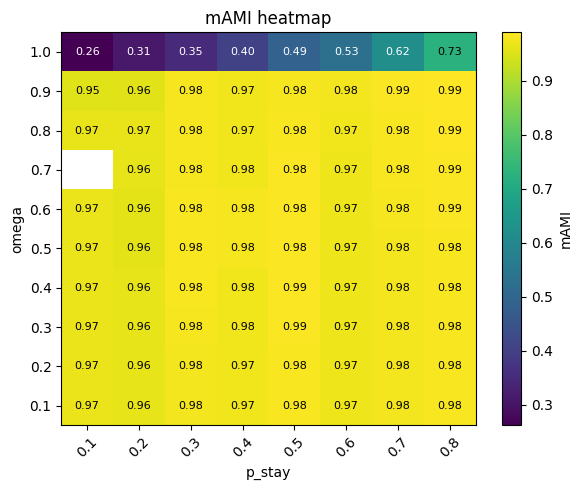

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 计算平均值 ===
genlouvain_heat_df = (
    genlouvan_results_df
    .groupby(["omega", "p_stay"], as_index=False)["mami"]
    .mean()
)

# === 获取唯一取值 ===
omega_unique = sorted(genlouvain_heat_df["omega"].unique())
p_stay_unique = sorted(genlouvain_heat_df["p_stay"].unique())

# === 生成透视表 ===
pivot_mat = genlouvain_heat_df.pivot(index="omega", columns="p_stay", values="mami")
pivot_mat = pivot_mat.reindex(index=omega_unique, columns=p_stay_unique)

# === 绘图 ===
fig, ax = plt.subplots(figsize=(6, 5))

vmin = genlouvain_heat_df["mami"].min()
vmax = genlouvain_heat_df["mami"].max()

im = ax.imshow(
    pivot_mat.values,
    aspect="auto",
    origin="lower",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis"
)

# === 坐标轴 ===
ax.set_xticks(range(len(p_stay_unique)))
ax.set_xticklabels([str(v) for v in p_stay_unique], rotation=45)
ax.set_yticks(range(len(omega_unique)))
ax.set_yticklabels([str(v) for v in omega_unique])

ax.set_xlabel("p_stay")
ax.set_ylabel("omega")
ax.set_title("mAMI heatmap")

# === 数值标注 ===
for i_rate, rate_val in enumerate(omega_unique):
    for j_p, pstay_val in enumerate(p_stay_unique):
        val = pivot_mat.loc[rate_val, pstay_val]
        if pd.notna(val):
            text_color = "white" if val < (vmin + vmax) / 2 else "black"
            ax.text(
                j_p,
                i_rate,
                f"{val:.2f}",
                ha="center",
                va="center",
                fontsize=8,
                color=text_color
            )

# === colorbar ===
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("mAMI")

plt.tight_layout()
plt.show()

## IterModMax
Find a suitable inter-layer coupling strength by the equivalence between SBM and modualarity maximisation. However, the coupling stength between state-node pairs are still homogenous. 

In [3]:
import algorithms, measurement, importlib
importlib.reload(algorithms)
importlib.reload(measurement)
from algorithms import *
from measurement import *

import glob
import os
import re
import pandas as pd
import matplotlib.pyplot as plt


# ---------- 文件名解析 ----------
def parse_filename(path: str):
    fname = os.path.basename(path)
    m = re.match(r"const-p(\d+)\.csv", fname)
    if not m:
        raise ValueError(f"无法解析文件名: {fname}")

    pstay_tag = m.group(1)   # '04'

    def tag_to_float(tag: str) -> float:
        # '01' -> '0.1', '04' -> '0.4', '10' -> '1.0'
        if len(tag) == 1:
            # e.g. '5' -> '0.5'
            s = f"0.{tag}"
        else:
            s = tag[0] + "." + tag[1:]
        return float(s)
    p_stay_val = tag_to_float(pstay_tag)
    return p_stay_val

omega_vals = [1.0]
csv_files = glob.glob("sync_data/const-p*.csv")

records = []

for file_path in csv_files:
    p_stay_val = parse_filename(file_path)
    print(f"\nProcessing file: {file_path} p_stay={p_stay_val})")

    for omega in omega_vals:
        try:
            partition = genlouvain_communities(
                            input_csv=file_path,
                            output_csv=None,
                            omega=omega,
                            gamma=1.0,
                            directed=False,
                            random_state=None,
                            algorithm="itermodmax",
                        )
            mami = compute_layerwise_ami_avg(file_path, partition)

            records.append({
                "p_stay": p_stay_val,
                "omega": omega,
                "mami": mami,
                "file": os.path.basename(file_path),
            })

        except Exception as e:
            print(f"Error: {e}")

genlouvan_results_df = pd.DataFrame(records)



Processing file: sync_data/const-p07.csv p_stay=0.7)
Initialisation: gamma = 1.00, omega = 1.00
Iteration 1: gamma = 1.00, omega = 1.00, p = 0.70, K = 10
Iteration 2: gamma = 1.76, omega = 0.51, p = 0.69, K = 10
Final values: gamma = 1.76, omega = 0.50

Optimal values: gamma = 1.76, omega = 0.51

[0.9892849583108991, 0.9952075401438528, 0.9901026711936106, 0.9999999999999998, 0.9831999167310849]

Processing file: sync_data/const-p06.csv p_stay=0.6)
Initialisation: gamma = 1.00, omega = 1.00
Iteration 1: gamma = 1.00, omega = 1.00, p = 0.60, K = 10
Iteration 2: gamma = 1.79, omega = 0.45, p = 0.60, K = 11
Final values: gamma = 1.79, omega = 0.46

Optimal values: gamma = 1.79, omega = 0.45

[0.9776658670506585, 0.9865877811986351, 0.9713562349660019, 0.9652928174369101, 0.9780374281571075]

Processing file: sync_data/const-p04.csv p_stay=0.4)
Initialisation: gamma = 1.00, omega = 1.00
Iteration 1: gamma = 1.00, omega = 1.00, p = 0.42, K = 10
Iteration 2: gamma = 1.56, omega = 0.36, p = 

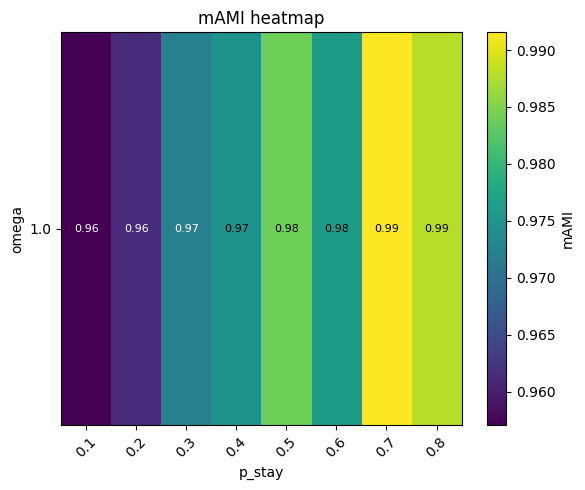

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

genlouvain_heat_df = (
    genlouvan_results_df
    .groupby(["omega", "p_stay"], as_index=False)["mami"]
    .mean()
)

# === 获取唯一取值 ===
omega_unique = sorted(genlouvain_heat_df["omega"].unique())
p_stay_unique = sorted(genlouvain_heat_df["p_stay"].unique())

# === 生成透视表 ===
pivot_mat = genlouvain_heat_df.pivot(index="omega", columns="p_stay", values="mami")
pivot_mat = pivot_mat.reindex(index=omega_unique, columns=p_stay_unique)

# === 绘图 ===
fig, ax = plt.subplots(figsize=(6, 5))

vmin = genlouvain_heat_df["mami"].min()
vmax = genlouvain_heat_df["mami"].max()

im = ax.imshow(
    pivot_mat.values,
    aspect="auto",
    origin="lower",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis"
)

# === 坐标轴 ===
ax.set_xticks(range(len(p_stay_unique)))
ax.set_xticklabels([str(v) for v in p_stay_unique], rotation=45)
ax.set_yticks(range(len(omega_unique)))
ax.set_yticklabels([str(v) for v in omega_unique])

ax.set_xlabel("p_stay")
ax.set_ylabel("omega")
ax.set_title("mAMI heatmap")

# === 数值标注 ===
for i_rate, rate_val in enumerate(omega_unique):
    for j_p, pstay_val in enumerate(p_stay_unique):
        val = pivot_mat.loc[rate_val, pstay_val]
        if pd.notna(val):
            text_color = "white" if val < (vmin + vmax) / 2 else "black"
            ax.text(
                j_p,
                i_rate,
                f"{val:.2f}",
                ha="center",
                va="center",
                fontsize=8,
                color=text_color
            )

# === colorbar ===
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("mAMI")

plt.tight_layout()
plt.show()

## GW coupling

In [ ]:
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import networkx as nx

# ========= CONFIG =========
CSV_PATH = "sync_data/test.csv"
# node2vec
DIMENSIONS = 32
WALK_LENGTH = 80
NUM_WALKS = 10
P = 1.0
Q = 1.0
WINDOW = 10
WORKERS = 4
SEED = 42
# GW & interlayer linking
GW_EMB_METRIC = "euclidean"       # 'euclidean' or 'cosine'
TOP_K = 5                         # 每个源节点跨层只保留前 K 个目标
MIN_WEIGHT = 1e-3                 # 小于阈值的跨层边丢弃
ALPHA = 2.0                       # 层间全局缩放 Omega = exp(-ALPHA * GW)
INTRA_EDGE_WEIGHT = 1.0           # 层内边权（CSV 若无权重，就用常数 1）

# ========= deps =========
from node2vec import Node2Vec
from ot.gromov import gromov_wasserstein, gromov_wasserstein2
from infomap import Infomap


# ---------- data / graphs ----------
def read_edges(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    req = {"u", "v", "layer"}
    miss = req - set(df.columns)
    if miss:
        raise ValueError(f"CSV missing required columns: {sorted(miss)}")
    # 统一为字符串 id
    df["u"] = df["u"].astype(str)
    df["v"] = df["v"].astype(str)
    df["layer"] = df["layer"].astype(str)
    return df

def build_layer_graphs(df: pd.DataFrame) -> Dict[str, nx.Graph]:
    graphs: Dict[str, nx.Graph] = {}
    for layer, gdf in df.groupby("layer"):
        G = nx.Graph()
        if "w" in gdf.columns:
            edges = [(u, v, float(w)) for u, v, w in gdf[["u", "v", "w"]].itertuples(index=False)]
            G.add_weighted_edges_from(edges)
        else:
            G.add_edges_from(gdf[["u", "v"]].itertuples(index=False, name=None))
            # 给无权图统一权重 1
            nx.set_edge_attributes(G, INTRA_EDGE_WEIGHT, "weight")
        # 确保孤立点也在图里（如果 CSV 有只出现一次的端点）
        for col in ["u", "v"]:
            for n in gdf[col].unique():
                if n not in G:
                    G.add_node(n)
        graphs[layer] = G
    return graphs


# ---------- embeddings ----------
def compute_node2vec_embeddings(
    G: nx.Graph,
    dimensions=64, walk_length=80, num_walks=10, p=1.0, q=1.0,
    window=10, workers=1, seed=42
) -> pd.DataFrame:
    if len(G) == 0:
        raise ValueError("Empty graph.")
    def _fit(n_jobs):
        n2v = Node2Vec(G, dimensions=dimensions, walk_length=walk_length,
                       num_walks=num_walks, p=p, q=q, workers=n_jobs,
                       seed=seed, quiet=True)
        return n2v.fit(window=window, min_count=1, batch_words=4)
    try:
        model = _fit(workers)
    except Exception as e:
        print(f"[WARN] node2vec workers={workers} failed: {e}. Fallback to workers=1.")
        model = _fit(1)
    nodes = [str(n) for n in G.nodes()]
    X = np.vstack([model.wv[n] for n in nodes])
    emb = pd.DataFrame(X, index=nodes, columns=[f"f{i}" for i in range(X.shape[1])])
    emb.index.name = "node"
    return emb

def pairwise_from_embeddings(emb: pd.DataFrame, metric="euclidean") -> np.ndarray:
    X = emb.values.astype(float)
    if metric == "euclidean":
        s = np.sum(X * X, axis=1, keepdims=True)
        D2 = s + s.T - 2 * (X @ X.T)
        np.maximum(D2, 0.0, out=D2)
        return np.sqrt(D2, dtype=float)
    elif metric == "cosine":
        n = np.linalg.norm(X, axis=1, keepdims=True)
        n[n == 0] = 1.0
        Xn = X / n
        S = np.clip(Xn @ Xn.T, -1.0, 1.0)
        return 1.0 - S
    else:
        raise ValueError("metric must be 'euclidean' or 'cosine'.")

def gw_coupling_and_distance(emb1: pd.DataFrame, emb2: pd.DataFrame, metric="euclidean"):
    emb1 = emb1.sort_index()
    emb2 = emb2.sort_index()
    nodes1 = emb1.index.to_list()
    nodes2 = emb2.index.to_list()
    C1 = pairwise_from_embeddings(emb1, metric=metric)
    C2 = pairwise_from_embeddings(emb2, metric=metric)
    n1, n2 = C1.shape[0], C2.shape[0]
    p = np.ones(n1) / max(n1, 1)
    q = np.ones(n2) / max(n2, 1)
    # π（最优耦合，带熵正则版可用 ot.gromov.entropic_gromov_wasserstein）
    pi = gromov_wasserstein(C1, C2, p, q, loss_fun="square_loss")
    # GW^2
    gw2 = gromov_wasserstein2(C1, C2, p, q, loss_function="square_loss")
    gw = float(np.sqrt(max(gw2, 0.0)))
    return pi, nodes1, nodes2, gw

def state_id(node: str, layer: str) -> str:
    # 选择一个不太可能出现在节点/层名里的分隔符
    return f"{node}|{layer}"


def build_infomap_with_gw(
    graphs: Dict[str, nx.Graph],
    embeddings: Dict[str, pd.DataFrame],
    layer_order: List[str],
    top_k: int = 5,
    min_weight: float = 1e-3,
    alpha: float = 2.0,
    emb_metric: str = "euclidean",
    intra_weight_from_attr: str = "weight"
) -> Tuple[Infomap, Dict[int, Tuple[str, str]]]:
    """
    构造扁平化“状态节点图”，节点是 (node, layer) 的组合映射为 int。
    返回 (Infomap实例, id2state)，其中 id2state[i] = (node, layer)
    """

    # ----------- 1️⃣ 建立全局状态节点映射 -----------
    state2id = {}
    id2state = {}
    next_id = 1

    # 遍历所有层的所有节点，创建唯一的整数ID
    for layer in layer_order:
        for n in graphs[layer].nodes():
            key = (str(n), str(layer))
            state2id[key] = next_id
            id2state[next_id] = key
            next_id += 1

    im = Infomap("--two-level --silent")

    # ----------- 2️⃣ 层内边 -----------
    for layer in layer_order:
        G = graphs[layer]
        for u, v, d in G.edges(data=True):
            w = float(d.get(intra_weight_from_attr, INTRA_EDGE_WEIGHT))
            uid = state2id[(str(u), str(layer))]
            vid = state2id[(str(v), str(layer))]
            im.addLink(int(uid), int(vid), float(w))

        # 如果整层没有边，加极小自环，保证节点可见
        if G.number_of_edges() == 0:
            for n in G.nodes():
                nid = state2id[(str(n), str(layer))]
                im.addLink(int(nid), int(nid), 1e-12)

    # ----------- 3️⃣ 层间边 (GW 耦合) -----------
    for t in range(len(layer_order) - 1):
        la, lb = layer_order[t], layer_order[t + 1]
        emb_a, emb_b = embeddings[la].sort_index(), embeddings[lb].sort_index()
        pi, nodes_a, nodes_b, gw = gw_coupling_and_distance(emb_a, emb_b, metric=emb_metric)

        Omega = float(np.exp(-alpha * gw))  # 全局缩放
        row_sums = pi.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        P = pi / row_sums

        na, nb = P.shape
        for ia in range(na):
            k_use = min(top_k, nb) if top_k > 0 else nb
            idx = np.argpartition(-P[ia, :], kth=k_use - 1)[:k_use]
            idx = idx[np.argsort(-P[ia, idx])]

            src_name = nodes_a[ia]
            src_id = state2id[(str(src_name), str(la))]

            for jb in idx:
                w = float(P[ia, jb]) * Omega
                if w < min_weight:
                    continue
                dst_name = nodes_b[jb]
                dst_id = state2id[(str(dst_name), str(lb))]
                im.addLink(int(src_id), int(dst_id), float(w))

    return im, id2state


# ============ RUN ============
df = read_edges(CSV_PATH)
graphs = build_layer_graphs(df)
layer_names = sorted(graphs.keys(), key=lambda x: x)  # 你也可以自定义顺序

# 逐层嵌入
embeddings: Dict[str, pd.DataFrame] = {}
for layer in layer_names:
    embeddings[layer] = compute_node2vec_embeddings(
        graphs[layer],
        dimensions=DIMENSIONS, walk_length=WALK_LENGTH, num_walks=NUM_WALKS,
        p=P, q=Q, window=WINDOW, workers=WORKERS, seed=SEED
    )

    
im, id2state = build_infomap_with_gw(
    graphs, embeddings, layer_order=layer_names,
    top_k=TOP_K, min_weight=MIN_WEIGHT, alpha=ALPHA, emb_metric=GW_EMB_METRIC
)

im.run()

# 提取社区划分结果
partition = {n.node_id: n.module_id for n in im.tree if n.is_leaf}

# 映射回 (node, layer)
rows = []
for nid, com in partition.items():
    if nid in id2state:
        node, layer = id2state[nid]
        rows.append((node, layer, com))

assignments_df = pd.DataFrame(rows, columns=["node_id", "layer", "community"])
assignments_df.to_csv("out/infomap_state_nodes.csv", index=False)
print(f"Saved community assignments -> out/infomap_state_nodes.csv ({len(rows)} nodes)")


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Saved community assignments -> out/infomap_state_nodes.csv (1820 nodes)
